# MHC Binding Prediction

In [1]:
import pandas as pd
import numpy as np
import numpy as np
import pandas as pd

import sys, os, math, re

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score, auc
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import f1_score

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
import xgboost as xgb

import time
from IPython.display import display

import csv

%matplotlib inline

feature generation
every 2 AA to generate 400 features, total 8x400 features


In [2]:
def BuildBlosum62():
    df = pd.read_csv('blosum62.csv')
    print(df)
    head = df.columns.tolist()
    return df

def GetSimilarMatrix(df, aa0, aa1):
    return df.loc[aa0, aa1]

aminolist = ["A", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "P", "Q", "R", "S", "T", "V", "W", "Y"]

def BuildFeature(df, seq, type='sparse'):
    row = {}
    # not all datasets are 9 AA long
    #for i in range(len(seq)-1):
    for i in range(8):
        for r in aminolist:
            for c in aminolist:
                score1 = GetSimilarMatrix(df, seq[i:i+1], r)
                score2 = GetSimilarMatrix(df, seq[i+1:i+2], c)
                if type == 'sparse':
                    row[str(i)+'_'+r+c] = score1 + score2
                else:
                    row[r+c] = row[r+c] + score1 + score2
    return row

In [3]:
# sliding window
def sliding_df (seq_len, sliding_window, dataset):
    seq_len = 9
    sliding_window = 3
    columns = []
    for i in range(seq_len-sliding_window+1):
        columns.append('ss' + str(i))
        dataset['ss' + str(i)] = dataset['sequence'].str[i:i+sliding_window]

    def encoder(df):
        for col in columns:
            label_encoder = LabelEncoder()
            label_encoder.fit(df[col])
            df[col] = label_encoder.transform(df[col])
        return df

    y = dataset['class']
    print(dataset)
    X = dataset.drop(['sequence', 'class'], axis=1)
    X = encoder(X)
    return X, y

def auc_score(true,sc,cutoff=None):
    if cutoff!=None:
        true = (true<=cutoff).astype(int)
        sc = (sc<=cutoff).astype(int)        
    fpr, tpr, thresholds = roc_curve(true, sc, pos_label=1)
    r = auc(fpr, tpr)
    #print (r)
    return  r

def show_roc_curve(y_test, y_pred):
    auc_roc = roc_auc_score(y_test, y_pred)
    print("AUC-ROC:", auc_roc)
    
    # Compute micro-average ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test, y_pred)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc_roc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

def LoadDataset(pos_file, neg_file):
    features = []
    classes = []

    with open(os.path.join('dataset', pos_file), 'r', encoding='utf-8') as pep_input:
        for line in pep_input:
            if re.match(line, '^#'):
                continue 
            line = line.strip()
            if line.isalpha():
                seq=str(line).upper()
                features.append(seq)
                classes.append(1)

    with open(os.path.join('dataset', neg_file), 'r', encoding='utf-8') as pep_input:
        for line in pep_input:
            if re.match(line, '^#'):
                continue
            line = line.strip()
            if line.isalpha():
                seq=str(line).upper()
                features.append(seq)
                classes.append(0)

    dataset = pd.DataFrame(
        {
            'sequence': features,
            'class': classes
        }
    )

    print(dataset)

    labels = ["Binded",'Not binded']
    values = dataset['class'].value_counts()[[1,0]].values
    fig1, ax1 = plt.subplots()
    ax1.pie(values, labels=labels,  autopct='%1.1f%%')
    plt.show()

    return dataset

       sequence  class
0     AIIDYIAYM      1
1     AIYDTMQYV      1
2     ALATFTVNI      1
3     ALDEGLLPV      1
4     ALFPIIWAL      1
...         ...    ...
9046  KEGAFFLYD      0
9047  KTLCDMIKG      0
9048  RRTRREAIV      0
9049  MMVIFRLMR      0
9050  GKRSNTTGK      0

[9051 rows x 2 columns]


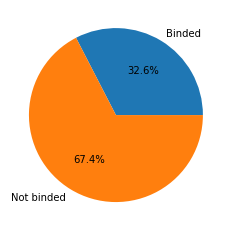

      sequence  class
0    STAFDFLAV      1
1    SQSPSSFSM      1
2    FALGNVISA      1
3    KINLSLFAL      1
4    LLDSLPMDV      1
..         ...    ...
339          /      0
340  ARDIYRASY      0
341          /      0
342          /      0
343          /      0

[344 rows x 2 columns]


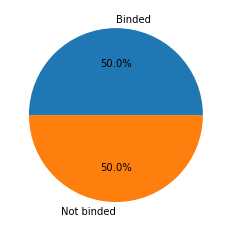

        sequence  class
0      KMVELVHFL      1
1      MIKNLTQLF      1
2      TQDLVQEKY      1
3      LRFPGQLNA      1
4      KVYDKLFPV      1
...          ...    ...
17341  TLNAWVKVV      0
17342  TLRKERLAK      0
17343  FYLYLTFYF      0
17344  FYPINDDFY      0
17345  KLDDVEKEK      0

[17346 rows x 2 columns]


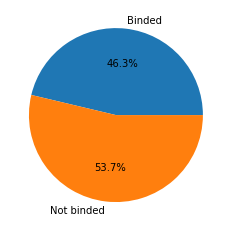

       sequence  class
0     LTMDREMLY      1
1     GMVTLYLGV      1
2     IMSLFSTSA      1
3     SASRAWNVW      1
4     ILIEGVFFA      1
...         ...    ...
2804  IVNNQESNK      0
2805  NEEVAIILA      0
2806  STYGISEDL      0
2807  HAPWTQMAM      0
2808  LSDAARLFL      0

[2809 rows x 2 columns]


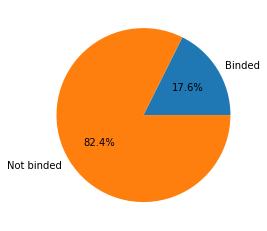

In [4]:
dataset1 = LoadDataset(pos_file='Positive_A0201_9AA_binder_pep.txt', neg_file='Negative_A0201_9AA_nonbinder_pep.txt')
dataset_cancer = LoadDataset(pos_file='dbPepNeo_HC_neoantigens_positive.txt', neg_file='dbPepNeo_HC_neoantigens_negative.txt')
dataset_fxxx = LoadDataset(pos_file='f123_ba_positive.txt', neg_file='f000_ba_negative.txt')
dataset_cxxx = LoadDataset(pos_file='c000_ba_test_positive.txt', neg_file='c000_ba_test_negative.txt')

Experiment: generate 8x400 feature table

In [5]:
scoreTable = BuildBlosum62()

X_list = []
y_list = []
#for ds in [dataset1, dataset_cancer, dataset_fxxx, dataset_cxxx]:
for ds in [dataset_fxxx, dataset_cxxx, dataset_cancer]:
    X_ = []
    y_ = []
    start = time.time()
    for i in range(len(ds)):
        #feat = BuildFeature(df=scoreTable, seq=ds.loc[i, 'sequence'], type='sparse')
        feat = BuildFeature(df=scoreTable, seq=ds.loc[i, 'sequence'], type='condense')
        X_.append(feat)
        y_.append(ds.loc[i, 'class'])

    X_ = pd.DataFrame(X_)
    y_ = pd.DataFrame(y_)
    print(X_)

    X_.to_csv('X.csv', encoding='utf-8', index=False)

    X_list.append(X_)
    y_list.append(y_)
    end = time.time()
    print("Time to build feature vector: {} sec".format(end-start))

X = X_list[0]
y = y_list[0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17, stratify=y)
print(X_train)


   A  R  N  D  C  Q  E  G  H  I  ...  K  M  F  P  S  T   W  Y  V  X
A  4 -1 -2 -2  0 -1 -1  0 -2 -1  ... -1 -1 -2 -1  1  0  -3 -2  0  0
R -1  5  0 -2 -3  1  0 -2  0 -3  ...  2 -1 -3 -2 -1 -1  -3 -2 -3 -1
N -2  0  6  1 -3  0  0  0  1 -3  ...  0 -2 -3 -2  1  0  -4 -2 -3 -1
D -2 -2  1  6 -3  0  2 -1 -1 -3  ... -1 -3 -3 -1  0 -1  -4 -3 -3 -1
C  0 -3 -3 -3  9 -3 -4 -3 -3 -1  ... -3 -1 -2 -3 -1 -1  -2 -2 -1 -2
Q -1  1  0  0 -3  5  2 -2  0 -3  ...  1  0 -3 -1  0 -1  -2 -1 -2 -1
E -1  0  0  2 -4  2  5 -2  0 -3  ...  1 -2 -3 -1  0 -1  -3 -2 -2 -1
G  0 -2  0 -1 -3 -2 -2  6 -2 -4  ... -2 -3 -3 -2  0 -2  -2 -3 -3 -1
H -2  0  1 -1 -3  0  0 -2  8 -3  ... -1 -2 -1 -2 -1 -2  -2  2 -3 -1
I -1 -3 -3 -3 -1 -3 -3 -4 -3  4  ... -3  1  0 -3 -2 -1  -3 -1  3 -1
L -1 -2 -3 -4 -1 -2 -3 -4 -3  2  ... -2  2  0 -3 -2 -1  -2 -1  1 -1
K -1  2  0 -1 -3  1  1 -2 -1 -3  ...  5 -1 -3 -1  0 -1  -3 -2 -2 -1
M -1 -1 -2 -3 -1  0 -2 -3 -2  1  ... -1  5  0 -2 -1 -1  -1 -1  1 -1
F -2 -3 -3 -3 -2 -3 -3 -3 -1  0  ... -3  0  6 -4

KeyError: ''

In [7]:
X_list = []
y_list = []

for ds in [dataset1, dataset_cancer, dataset_fxxx, dataset_cxxx]:
    X_, y_ = sliding_df (seq_len = 9, sliding_window = 9, dataset = ds)
    print(X_[0:5])
    X_list.append(X_)
    y_list.append(y_)

X = X_list[2]
y = y_list[2]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17, stratify=y)

       sequence  class  ss0  ss1  ss2  ss3  ss4  ss5  ss6
0     AIIDYIAYM      1  AII  IID  IDY  DYI  YIA  IAY  AYM
1     AIYDTMQYV      1  AIY  IYD  YDT  DTM  TMQ  MQY  QYV
2     ALATFTVNI      1  ALA  LAT  ATF  TFT  FTV  TVN  VNI
3     ALDEGLLPV      1  ALD  LDE  DEG  EGL  GLL  LLP  LPV
4     ALFPIIWAL      1  ALF  LFP  FPI  PII  IIW  IWA  WAL
...         ...    ...  ...  ...  ...  ...  ...  ...  ...
9046  KEGAFFLYD      0  KEG  EGA  GAF  AFF  FFL  FLY  LYD
9047  KTLCDMIKG      0  KTL  TLC  LCD  CDM  DMI  MIK  IKG
9048  RRTRREAIV      0  RRT  RTR  TRR  RRE  REA  EAI  AIV
9049  MMVIFRLMR      0  MMV  MVI  VIF  IFR  FRL  RLM  LMR
9050  GKRSNTTGK      0  GKR  KRS  RSN  SNT  NTT  TTG  TGK

[9051 rows x 9 columns]
   ss0   ss1   ss2   ss3   ss4   ss5   ss6
0   62   904  1504   669  4343  1443   196
1   73  1091  4253   627  3728  2377  2261
2   79  1186   242  3738  1060  3840  2887
3   81  1209   427   759  1221  2093  1565
4   83  1257  1006  2806  1614  1703  2981
      sequence  class

In [8]:
decision_tree = DecisionTreeClassifier(random_state=3)

decision_tree.fit(X_train, y_train)

prediction_tree = decision_tree.predict(X_test)

print("========= training dataset  ================")

print("Test result (accuracy):", decision_tree.score(X_test, y_test))

auc_roc_tree = roc_auc_score(y_test, prediction_tree)

print("AUC-ROC:", auc_roc_tree)

print("F-measure: ", f1_score(y_test, prediction_tree > 0.48))

for i in range(2):
    print("========= dataset {} ================".format(str(i)))
    prediction_tree = decision_tree.predict(X_list[i])
    print("Test result (accuracy):", decision_tree.score(X_list[i], y_list[i]))
    auc_roc_tree = roc_auc_score(y_list[i], prediction_tree)
    print("AUC-ROC:", auc_roc_tree)
    print("F-measure: ", f1_score(y_list[i], prediction_tree > 0.48))

========= training dataset  ================
Test result (accuracy): 0.8478093774019985
AUC-ROC: 0.8544791681519397
F-measure:  0.8516298239040839
========= dataset 0 ================
Test result (accuracy): 0.6137443376422494
AUC-ROC: 0.5161542519121359
F-measure:  0.2847790507364975
========= dataset 1 ================
Test result (accuracy): 0.4266666666666667
AUC-ROC: 0.49900072674418605
F-measure:  0.011494252873563218
========= dataset 2 ================
Test result (accuracy): 0.9543410584572812
AUC-ROC: 0.9563375818248493
F-measure:  0.9522258414766558
========= dataset 3 ================
Test result (accuracy): 0.6774652901388395
AUC-ROC: 0.49297730983124244
F-measure:  0.1852517985611511


In [9]:
bagging = BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=3), n_estimators=100)

bagging.fit(X_train, y_train)

prediction_bagging = bagging.predict(X_test)

auc_roc_tree = roc_auc_score(y_test, prediction_bagging)

print("AUC-ROC:", auc_roc_tree)

print("F-measure: ", f1_score(y_test, prediction_bagging > 0.48))

AUC-ROC: 0.9068804984814567
F-measure:  0.9013532065110805


[0]	train-auc:0.71861
[1]	train-auc:0.73908
[2]	train-auc:0.74737
[3]	train-auc:0.75160
[4]	train-auc:0.75884
[5]	train-auc:0.76107
[6]	train-auc:0.76578
[7]	train-auc:0.77187
[8]	train-auc:0.77954
[9]	train-auc:0.78209
[10]	train-auc:0.78795
[11]	train-auc:0.79170
[12]	train-auc:0.79534
[13]	train-auc:0.80198
[14]	train-auc:0.80445
[15]	train-auc:0.80888
[16]	train-auc:0.81262
[17]	train-auc:0.81805
[18]	train-auc:0.82084
[19]	train-auc:0.82562
[20]	train-auc:0.82975
[21]	train-auc:0.83312
[22]	train-auc:0.83712
[23]	train-auc:0.84084
[24]	train-auc:0.84399
[25]	train-auc:0.84647
[26]	train-auc:0.84772
[27]	train-auc:0.84986
[28]	train-auc:0.85271
[29]	train-auc:0.85425
[30]	train-auc:0.85586
[31]	train-auc:0.85900
[32]	train-auc:0.86081
[33]	train-auc:0.86254
[34]	train-auc:0.86336
[35]	train-auc:0.86707
[36]	train-auc:0.87216
[37]	train-auc:0.87347
[38]	train-auc:0.87536
[39]	train-auc:0.87658
[40]	train-auc:0.87816
[41]	train-auc:0.88020
[42]	train-auc:0.88176
[43]	train-auc:0.8830

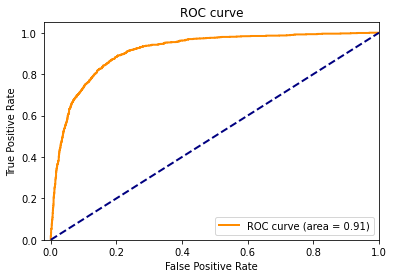

========= dataset 3 ================
AUC-ROC: 0.4841993836375859


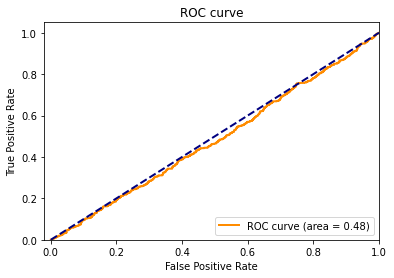

In [10]:

params = {
    "objective": "binary:logistic",
    "booster": "gbtree",
    "eval_metric": "auc",
    "eta": 0.1,
    "min_child_weight": 1,
    "max_depth": 6,
    "nthread": 4
}

xgb_train = xgb.DMatrix(X_train.values, y_train.values)
xgb_test = xgb.DMatrix(X_test.values)

num_round = 300
watchlist = [(xgb_train, 'train')]
start = time.time()
model = xgb.train(params, xgb_train, num_round, watchlist)
end = time.time()
print("Time to train: {} sec".format(end-start))

print("========= training dataset ================")
y_pred = model.predict(xgb_test)
show_roc_curve(y_test = y_test, y_pred = y_pred)

xgb_test = xgb.DMatrix(X_list[1].values)
y_pred = model.predict(xgb_test)

print("========= dataset cxxx ================")
show_roc_curve(y_test = y_list[1], y_pred = y_pred)

xgb_test = xgb.DMatrix(X_list[2].values)
y_pred = model.predict(xgb_test)

print("========= dataset cancer ================")
show_roc_curve(y_test = y_list[2], y_pred = y_pred)


In [11]:
# X = X.append(X2)
# y = y.append(y2)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17, stratify=y)

# xgb_train = xgb.DMatrix(X_train.values, y_train.values)
# xgb_test = xgb.DMatrix(X_test.values)

# num_round = 300
# watchlist = [(xgb_train, 'train')]
# model = xgb.train(params, xgb_train, num_round, watchlist)

# y_pred = model.predict(xgb_test)

# auc_roc = roc_auc_score(y_test, y_pred)

# print("AUC-ROC:", auc_roc)

# # Compute micro-average ROC curve and ROC area
# fpr, tpr, _ = roc_curve(y_test, y_pred)

# plt.figure()
# lw = 2
# plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc_roc)
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([-0.02, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC curve')
# plt.legend(loc="lower right")
# plt.show()

In [12]:
# conda install -c conda-forge biopython
from Bio.SeqUtils.ProtParam import ProteinAnalysis
analyzed_seq = ProteinAnalysis(str(seq))
analyzed_seq.molecular_weight()
analyzed_seq.count_amino_acids()

{'A': 2,
 'C': 0,
 'D': 1,
 'E': 0,
 'F': 1,
 'G': 0,
 'H': 0,
 'I': 0,
 'K': 0,
 'L': 3,
 'M': 0,
 'N': 0,
 'P': 0,
 'Q': 0,
 'R': 1,
 'S': 1,
 'T': 0,
 'V': 0,
 'W': 0,
 'Y': 0}